# Create test set

In the file `explore_data.ipynb`, I found that a token cutoff of 3000 had over 95% of all tokens and articles. I also found that a cutoff of 30% symbol tokens captures about 90% of tokens and articles. In order to have a test set that is not to onerous to produce or too poor quality to recover I am going to combine both of these metrics

Need to do
- Load all articles, keep only the number of tokens, the page and the number of symbols
- sum to page level
- calc fract symbols
- review distribution
- minimum token count, maximum symbol fract
- subset pages
- sample

In [1]:
import pandas as pd
import tiktoken
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time  # Make sure to import the time module
import shutil
import PyPDF2

from llm_comparison_toolkit import RateLimiter, get_response_openai, get_response_anthropic,  create_config_dict_func, use_df_to_call_llm_api, compare_request_configurations


from helper_functions import find_pdf_path, stratified_target_sampling, files_to_df_func, get_tokens_symbols, load_articles_from_date


from dotenv import load_dotenv, find_dotenv
load_dotenv()

directory = './data/ncse_text_chunks'

dev_transcripts = 'data/dev_data_transcript'

dev_gpt4_results = 'data/dev_data_gpt-4-turbo-preview'
dev_gpt3_results = 'data/dev_data_gpt-3.5-turbo'

image_path = os.getenv("image_path")



Get the conversion from the publication ID to the folder path of the archived images from the NCSE figshare

In [2]:
folder2id_df = pd.DataFrame([{'folder':'English_Womans_Journal_issue_PDF_files', 'publication_id':24},
 {'folder':'Leader_issue_PDF_files/Leader_issue_PDF_files', 'publication_id':20},
 {'folder':'Monthly_Repository_issue_PDF_files', 'publication_id':22},
 {'folder':'Northern_Star_issue_PDF_files', 'publication_id':27},
 {'folder':'Publishers_Circular_issue_PDF_files', 'publication_id':26},
 {'folder':'Tomahawk_issue_PDF_files/Tomahawk_issue_PDF_files', 'publication_id':19}])

In [4]:
page_list = pd.read_parquet('data/periodicals_page.parquet')

periodicals_issue = pd.read_parquet('data/periodicals_issue.parquet')

periodicals_publication = pd.read_parquet('data/periodicals_publication.parquet')

page_info = page_list.rename(columns = {'number':'page_number'}).merge(
    periodicals_issue[['id', 'publication_id', 'issue_date']].rename(columns = {'id':'issue_id'}), on = 'issue_id'
).merge(
   periodicals_publication[['id', 'slug', 'title']].rename(columns = {'id':'publication_id'}), on='publication_id' 
)


In [5]:

df = get_tokens_symbols(directory)
df['symbol_fract'] = df['total_tokens']/df['symbol_count']
df = df.merge(folder2id_df, on = 'publication_id').merge(page_info, on = ['issue_id', 'page_number', 'publication_id'])

df['pdf_path'] = df.apply(lambda row: find_pdf_path(image_path, row['folder'],  row['issue_date'].strftime('%Y-%m-%d')), axis=1)

FileNotFoundError: [Errno 2] No such file or directory: './data/ncse_text_chunks'

In [28]:
#The percentiles are very different depending on the publication indicating the differences in style
df.groupby('publication_id')[['total_tokens','symbol_fract']].quantile([0.1, 0.9])

total_tokens  symbol_fract
publication_id                                
19             0.1           0.0      2.215173
               0.9        2905.5      7.401785
20             0.1        2590.0      4.046680
               0.9        4814.0      7.765424
22             0.1         628.0      3.988410
               0.9        1302.0      8.597403
24             0.1         615.0      5.700000
               0.9         906.0      9.616438
26             0.1         563.0      1.827979
               0.9        3804.9      4.232908
27             0.1       10190.2      4.265014
               0.9       17049.8      6.688719

In [29]:
df.groupby('publication_id')[['total_tokens','symbol_fract']].describe()

/home/jonno/redigitalize/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/jonno/redigitalize/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/jonno/redigitalize/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


total_tokens                                             \
                      count          mean          std   min       25%   
publication_id                                                           
19                   1896.0   1621.028481  1134.921656   0.0    457.75   
20                  24448.0   3618.727544   883.722034  33.0   3065.75   
22                  26743.0    952.304865   312.110114   0.0    726.00   
24                   5663.0    730.576550   134.483417   0.0    670.00   
26                  20822.0   2001.118913  1368.793948   0.0    948.00   
27                  17843.0  14113.945861  3315.907047   0.0  12989.00   

                                           symbol_fract                      \
                    50%       75%      max        count      mean       std   
publication_id                                                                
19               1838.5   2320.25   7086.0       1652.0       inf       NaN   
20               3513.0   3990.00  13202.0      24448.0  6.083151  1.418433   
22                935.0   1094.00   3259.0      26727.0       inf       NaN   
24                715.0    773.00   1866.0       5661.0  7.629707  1.635782   
26               1593.0   2925.75   9443.0      20812.0       inf       NaN   
27              14656.0  15783.00  44971.0      17838.0  5.542950  0.958686   

                                                                   
                     min       25%       50%       75%        max  
publication_id                                                     
19              0.376289  3.348244  4.712152  6.149362        inf  
20              1.586188  5.029889  6.290598  7.115217  10.617089  
22              0.554768  5.237088  6.460606  7.573478        inf  
24              1.670251  6.672727  7.630435  8.621622  14.431818  
26              0.432258  2.322350  3.019698  3.630401        inf  
27              1.487126  4.963906  5.610126  6.191888   9.293139

In [21]:
test = load_articles_from_date('1868-05-16', directory, min_tokens = 50)

test.to_csv('data/accidental_finder.csv')

In [17]:
df2.loc[df2['id'].isin([150954]),:]

,publication_id,issue_id,page_number,total_tokens,symbol_count,folder,id,height,image,width,article_count,label,issue_date,slug,title,pdf_path,symbol_fract
62340,26,4318,59,743,301,Publishers_Circular_issue_PDF_files,150954,1477,periodicals/099-TEC-1886-03-01-001-SINGLE/Pg05...,995,2,253,1886-03-01,pc,Publishers’ Circular (1880-1890),/media/jonno/ncse/Publishers_Circular_issue_PD...,2.468439


In [30]:
df2 = df.copy()

percentile_90 = df2.groupby('publication_id')['symbol_fract'].transform(lambda x: x.quantile(0.9))
df2 = df2.loc[(df2['total_tokens']>500) & (df2['symbol_fract'] <= percentile_90) & (df2['pdf_path'].notnull()),: ].reset_index(drop=True)

np.random.seed(1842)
pages_for_transcription_1 = stratified_target_sampling(df2, group_col = 'publication_id', value_col = 'total_tokens', target_value = 20000)


pages_for_transcription_1 = pd.concat([pages_for_transcription_1, 
                                       df2.loc[df2['id'].isin([97484, 163094, 90939, 93238, 92551, 150954, 160259, 160759, 160813]),:]], #accidental pages added on using page id
                                       ignore_index=True)
#pages_for_transcription_1

In [31]:
pages_for_transcription_1['file_name'] = pages_for_transcription_1['pdf_path'].apply(os.path.basename)
#process_pdfs(pages_for_transcription_1, output_folder="data/pdfs_for_transcription")

# Articles from pages

As the transcribed dataset is being constructed at page level, the raw ocr articles need to be extracted and placed in individual files

In [32]:
def get_articles_for_pages(page_df, vars_list, directory, min_tokens = 100):

    df_list = []

    for filename in os.listdir(directory):

        file_path = os.path.join(directory, filename)

        df = pd.read_parquet(file_path)
        
        df = df.loc[df['page_id'].isin(page_df['id'].unique()), vars_list]

        df_list.append(df)

        df = pd.concat(df_list, ignore_index=True)

        df = df.loc[df['total_tokens']>= min_tokens, :]

    return df

In [33]:
articles_to_transcribe_df = get_articles_for_pages(pages_for_transcription_1, 
                       ['id','content_html','page_id', 'file_name', 'site_address', 'total_tokens',	'symbol_count',	'symbol_fract', 'issue_date'],
                       directory)

articles_to_transcribe_df.to_csv('data/transcription_raw_ocr.csv')

In [23]:
articles_to_transcribe_df.loc[articles_to_transcribe_df['content_html'].str.contains("F TELEGRAPHIC ADDRESSES AND")]

,id,content_html,page_id,file_name,site_address,total_tokens,symbol_count,symbol_fract,issue_date
252,766216,'THE PUBLISHERS' CIRCULAR ' LIST OF TELEGRAPHI...,150954,slug_ad05908_periodical_pc_issue_tec_01031886_...,https://ncse.ac.uk/periodicals/pc/issues/tec_0...,117,28,0.239316,1886-03-01


## Copy pages for transcription

In [35]:
raw_ocr_folder = 'data/transcription_raw_ocr'
os.makedirs(raw_ocr_folder , exist_ok = True)

for index, row in articles_to_transcribe_df.loc[articles_to_transcribe_df['total_tokens']>=100].iterrows():
    file_path = os.path.join(raw_ocr_folder , row['file_name'])
    # Write the contents_html to a file with the name file_name
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(row['content_html'])

## Get Opus estimate of ground truth

In [34]:
articles_to_transcribe_df

,id,content_html,page_id,file_name,site_address,total_tokens,symbol_count,symbol_fract,issue_date
1,508709,THE NATIONAL PABMAMENTARY BBFOBJC ASSOCIATION ...,97484,slug_ar00602_periodical_l_issue_vm2-ncseproduc...,https://ncse.ac.uk/periodicals/l/issues/vm2-nc...,248,47,0.189516,1852-04-24
2,508707,The sanitary duties now imposed on numerous ex...,97484,slug_ar00600_periodical_l_issue_vm2-ncseproduc...,https://ncse.ac.uk/periodicals/l/issues/vm2-nc...,1812,218,0.120309,1852-04-24
3,508708,ELECTIQN MATTERS . FACTS ABOUT THE ELECTIONS ....,97484,slug_ar00601_periodical_l_issue_vm2-ncseproduc...,https://ncse.ac.uk/periodicals/l/issues/vm2-nc...,1865,301,0.161394,1852-04-24
4,584080,Imperial and Boyal Privileged Company of the S...,107685,slug_ar01300_periodical_l_issue_vm2-ncseproduc...,https://ncse.ac.uk/periodicals/l/issues/vm2-nc...,416,43,0.103365,1855-03-17
5,584081,PRUSSIA PERELEXED . At the first Vienna Confer...,107685,slug_ar01301_periodical_l_issue_vm2-ncseproduc...,https://ncse.ac.uk/periodicals/l/issues/vm2-nc...,1691,233,0.137788,1855-03-17
...,...,...,...,...,...,...,...,...,...
361,802839,moted degeneracy Instead the following of of w...,160813,slug_ar00508_periodical_t_issue_ttw_16051868_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_16...,681,95,0.139501,1868-05-16
362,802838,season and freshness . The of heavy costume de...,160813,slug_ar00502_periodical_t_issue_ttw_16051868_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_16...,374,51,0.136364,1868-05-16
363,802841,"her "" Royal Her Majesty pleasure that has he i...",160813,slug_ar00504_periodical_t_issue_ttw_16051868_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_16...,202,32,0.158416,1868-05-16
364,802843,The Current Question . Why is Mr . Buckstone i...,160813,slug_ar00506_periodical_t_issue_ttw_16051868_p...,https://ncse.ac.uk/periodicals/t/issues/ttw_16...,342,84,0.245614,1868-05-16


In [23]:
#this is to create files of the correct name with the most likely text in place to make it easier for me to complete the text when the true transcriptions come in

full_prompt = "{content_html}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from an english newspaper in the 1800's. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""


config_dict = create_config_dict_func(
                get_response_func=get_response_anthropic,
                rate_limiter=RateLimiter(50000),
                engine="claude-3-opus-20240229",
                system_message_template="",
                prompt_template= full_prompt
            )

use_df_to_call_llm_api(config_dict, a, 'claude_temp' , folder_path='./data/transcription_returned_ocr')

# Load ground truth dataset

In [3]:
enc = tiktoken.encoding_for_model('gpt-3.5-turbo')

transcribed_data_set_df = files_to_df_func('data/transcription_returned_ocr/transcription_files')

transcribed_data_set_df['word_count'] = transcribed_data_set_df['content'].str.split().str.len()
#true tokens is used to differentiate it from the 'total_tokens' of the raw content
transcribed_data_set_df['true_tokens'] = transcribed_data_set_df['content'].apply(lambda x:len(enc.encode(x))) 
transcribed_data_set_df['true_chars'] = transcribed_data_set_df['content'].apply(lambda x:len(x)) 

print(transcribed_data_set_df[['true_chars','true_tokens', 'word_count']].sum())

transcribed_data_set_df[['true_chars', 'true_tokens', 'word_count']].describe()

true_chars     53271
true_tokens    12010
word_count      9167
dtype: int64


,true_chars,true_tokens,word_count
count,18.000000,18.000000,18.000000
mean,2959.500000,667.222222,509.277778
std,2787.563816,598.690979,481.763770
min,553.000000,111.000000,88.000000
25%,871.250000,182.000000,151.000000
50%,1558.000000,367.500000,260.000000
75%,3580.500000,877.500000,655.250000
max,8172.000000,1730.000000,1374.000000


In [75]:
9167/12010

0.7632805995004163

Text(0.5, 1.0, 'Relationship between tokens and words')

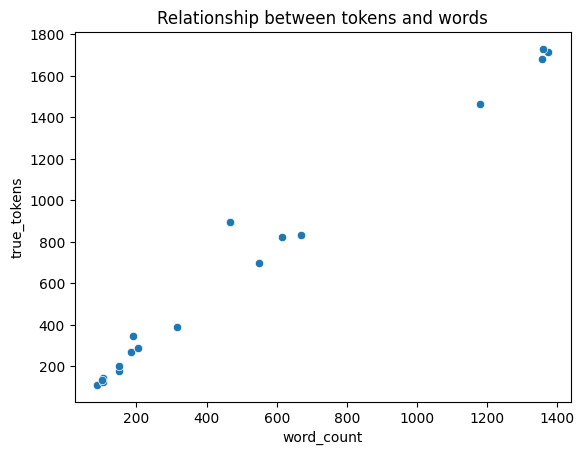

In [72]:
sns.scatterplot(data = transcribed_data_set_df, x = 'word_count', y = 'true_tokens')
plt.title('Relationship between tokens and words')

In [62]:
articles_to_transcribe_df.loc[articles_to_transcribe_df['file_name'].isin(transcribed_data_set_df['file_name']), 'total_tokens']

1       248
2      1812
3      1865
87      909
132    1726
133     138
134    1551
136     468
137     895
138     313
181     335
182     120
185     141
230     958
260     177
261     312
262     736
263     174
Name: total_tokens, dtype: int64